# Adam: Exercise

For this exercise we will be build Adam up from scratch starting with regular gradient descent. We will also be utilizing mini batches to introduce stochasticity to the optimization. 

We will be working with the mnist_784 data set and a simple shallow neural network. 

If you do not have scikit-learn then you can get it here: https://scikit-learn.org/stable/install.html

This code is heavily inspired by Doug’s code from CSCI 447/547 lecture 05_multilayer_perceptron.

First we need to get the data, define the network and define some functions to perform on the data. You don’t need to do anything with this first block of code. 

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X[::5]
y = y.astype(int)[::5]
X, X_test, y, y_test = train_test_split(X, y)

# Here we specify the size of our neural network.
# We are mapping from 784 to 10 with 256 hiden layer nodes.

m = len(X)
n_0 = 784
n_1 = 256
N = 10


# Function to convert categorical labels into one-hot matrix.
def convert_to_one_hot(y, n_classes):
    T = np.zeros((y.shape[0], n_classes))
    for t, yy in zip(T, y):
        t[yy] = 1
    return T


# Convert the data to one hot notation
one_hot_y_actual = convert_to_one_hot(y, N)
one_hot_y_test = convert_to_one_hot(y_test, N)


# Sigmoid function (activation)
def sigmoid(a):
    return 1. / (1 + np.exp(-a))


# Softmax function (final layer for classification)
def softmax(A):
    numerator = np.exp(A)
    denominator = numerator.sum(axis=1)
    return numerator / denominator[:, np.newaxis]


# Categorical cross-entropy
def L(T, S, W1, W2, alpha_1=1e-2, alpha_2=1e-5):
    return -1. / len(T) * np.sum(T * np.log(S)) + np.sum(0.5 * alpha_1 * W1 ** 2) + np.sum(0.5 * alpha_2 * W2 ** 2)


# Run the neural network forward, given some weights and biases
def feedforward(X, W1, W2, b1, b2):
    # Feedforward
    A1 = X @ W1 + b1
    Z1 = sigmoid(A1)
    A2 = Z1 @ W2 + b2
    y_pred = softmax(A2)
    return y_pred, Z1


# Compute the neural network gradients using backpropagation
def backpropogate(y_pred, Z1, X, y_obs, alpha_1=1e-2, alpha_2=1e-5):
    # Backpropogate
    delta_2 = (1. / len(y_pred)) * (y_pred - y_obs)
    grad_W2 = Z1.T @ delta_2 + alpha_2 * W2
    grad_b2 = delta_2.sum(axis=0)

    delta_1 = delta_2 @ W2.T * Z1 * (1 - Z1)
    grad_W1 = X.T @ delta_1 + alpha_1 * W1
    grad_b1 = delta_1.sum(axis=0)
    return grad_W1, grad_W2, grad_b1, grad_b2


def mini_batch(x_sample, y_sample, start_batch_size):
    """
    Takes a copy of x_sample and y_sample and returns mini batch matrices of both and number of batches
    """

    # Batches must divide evenly into total number of samples for numpy arrays to be happy.
    # Gets number of bathes by finding next smallest number that evenly divides
    num_batches = start_batch_size
    while len(x_sample) % num_batches != 0:
        num_batches -= 1

    # randomly shuffle indices
    np.random.seed(42)
    random_indices = np.random.choice(range(len(x_sample)), len(x_sample), replace=False)

    # instantiate lists to hold batches
    x_list = [[] for i in range(num_batches)]
    y_list = [[] for i in range(num_batches)]

    # populate batches matrix with random mini batch indices
    for i in range(len(x_sample)):

        x_list[i // 105].append(x_sample[random_indices[i]])
        y_list[i // 105].append(y_sample[random_indices[i]])
    
    # Convert to numpy arrays
    x_batch = np.array(x_list)
    y_batch = np.array(y_list)

    return x_batch, y_batch, num_batches, num_batches


# Vanilla Gradient Descent

For our first exercise we will implement plain old gradient descent. The mathematical formula is:

$$ \theta_t = \theta_{t-1} - \alpha \nabla f(\theta_{t-1}) \tag{1}$$
---

We have already specified initial values for the $\alpha$ and the batch size but feel free to play around with it. The location to insert your gradient descent implementation is outlined with a multi-line comment.  

In [5]:
"""
Vanilla Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
vanilla_loss = []

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)
        
        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        W1 -= grad_W1*eta
        W2 -= grad_W2*eta
        b1 -= grad_b1*eta
        b2 -= grad_b2*eta

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    vanilla_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305217 Accuracy 0.093429
Epoch 10 Loss 2.296406 Accuracy 0.093429
Epoch 20 Loss 2.286990 Accuracy 0.093429
Epoch 30 Loss 2.276500 Accuracy 0.125714
Epoch 40 Loss 2.264668 Accuracy 0.181429
Epoch 50 Loss 2.251347 Accuracy 0.224857
Epoch 60 Loss 2.236462 Accuracy 0.350857
Epoch 70 Loss 2.220033 Accuracy 0.486571
Epoch 80 Loss 2.202173 Accuracy 0.576286
Epoch 90 Loss 2.183033 Accuracy 0.624286
Epoch 100 Loss 2.162775 Accuracy 0.638571
Epoch 110 Loss 2.141567 Accuracy 0.646857
Epoch 120 Loss 2.119566 Accuracy 0.652286
Epoch 130 Loss 2.096917 Accuracy 0.656571
Epoch 140 Loss 2.073757 Accuracy 0.657143
Epoch 150 Loss 2.050209 Accuracy 0.658000
Epoch 160 Loss 2.026375 Accuracy 0.658000
Epoch 170 Loss 2.002355 Accuracy 0.659143
Epoch 180 Loss 1.978253 Accuracy 0.660286
Epoch 190 Loss 1.954149 Accuracy 0.660857
Epoch 200 Loss 1.930103 Accuracy 0.664571
Epoch 210 Loss 1.906167 Accuracy 0.667714
Epoch 220 Loss 1.882386 Accuracy 0.671714
Epoch 230 Loss 1.858799 Accuracy 0.675143
Epo

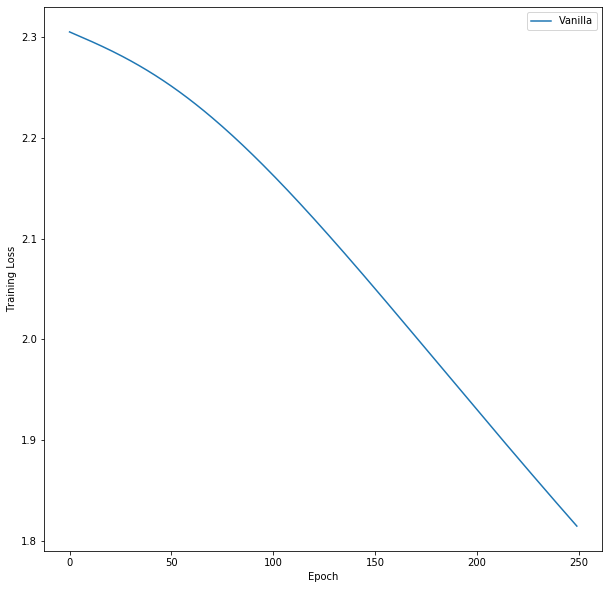

In [7]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Momentum Gradient Descent

Next we will add momentum. The the new update rule is:

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$ \beta_1 \in [0,1)$$
---

$$\theta_{t}=\theta_{t-1} - \alpha m_{t} \tag{2}$$
---

In [9]:

"""
Momentum Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
beta = .9
"""
You need to add another hyper parameter here. Hint! look at the equation above
"""

# data for analysis
momentum_loss = []

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

"""
You probably need to initialize your momentum here... 
"""
mom_W1 = 0
mom_W2 = 0
mom_b1 = 0
mom_b2 = 0

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        mom_W1 = beta*mom_W1 + (1-beta)*grad_W1
        mom_W2 = beta*mom_W2 + (1-beta)*grad_W2
        mom_b1 = beta*mom_b1 + (1-beta)*grad_b1
        mom_b2 = beta*mom_b2 + (1-beta)*grad_b2
        
        
        W1 -= mom_W1*eta
        W2 -= mom_W2*eta
        b1 -= mom_b1*eta
        b2 -= mom_b2*eta
        
    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    momentum_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305219 Accuracy 0.093429
Epoch 10 Loss 2.296408 Accuracy 0.093429
Epoch 20 Loss 2.286993 Accuracy 0.093429
Epoch 30 Loss 2.276504 Accuracy 0.125714
Epoch 40 Loss 2.264673 Accuracy 0.181429
Epoch 50 Loss 2.251353 Accuracy 0.224857
Epoch 60 Loss 2.236469 Accuracy 0.350857
Epoch 70 Loss 2.220041 Accuracy 0.486571
Epoch 80 Loss 2.202182 Accuracy 0.576286
Epoch 90 Loss 2.183043 Accuracy 0.624286
Epoch 100 Loss 2.162786 Accuracy 0.638571
Epoch 110 Loss 2.141578 Accuracy 0.646857
Epoch 120 Loss 2.119578 Accuracy 0.652286
Epoch 130 Loss 2.096931 Accuracy 0.656286
Epoch 140 Loss 2.073771 Accuracy 0.657143
Epoch 150 Loss 2.050223 Accuracy 0.658000
Epoch 160 Loss 2.026390 Accuracy 0.658000
Epoch 170 Loss 2.002370 Accuracy 0.658857
Epoch 180 Loss 1.978268 Accuracy 0.660286
Epoch 190 Loss 1.954164 Accuracy 0.660857
Epoch 200 Loss 1.930118 Accuracy 0.664571
Epoch 210 Loss 1.906182 Accuracy 0.667714
Epoch 220 Loss 1.882401 Accuracy 0.671714
Epoch 230 Loss 1.858813 Accuracy 0.675143
Epo

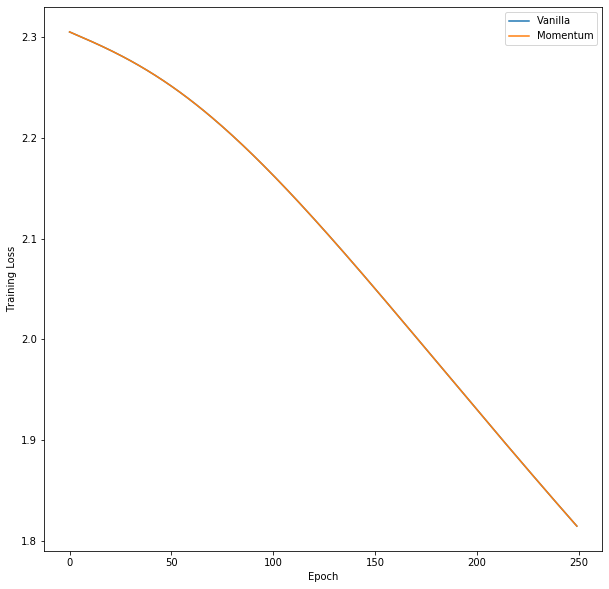

In [10]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# RMSProp Gradient Descent 

Next we will do RMSProp. The update rule is as follows:

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$ \beta_2 \in [0,1)$$
---

$$\theta_{t} = \theta_{t-1} - \alpha \frac { \nabla f(\theta_{t-1})}{\sqrt{v_{t} + \epsilon}} \tag{3}$$ 
---


In [14]:
"""
RMSProp Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add two hyper parameters here. Hint! look at the equation above
"""
epsilon = 1.0e-8
beta = .6

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
RMS_loss = []

"""
You probably need to initialize your variance here...
"""
var_W1 = 0
var_W2 = 0
var_b1 = 0
var_b2 = 0

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        var_W1 = beta*var_W1 + (1-beta)*grad_W1**2
        var_W2 = beta*var_W2 + (1-beta)*grad_W2**2
        var_b1 = beta*var_b1 + (1-beta)*grad_b1**2
        var_b2 = beta*var_b2 + (1-beta)*grad_b2**2
       
        W1 -= grad_W1/np.sqrt(var_W1+epsilon)*eta
        W2 -= grad_W2/np.sqrt(var_W2+epsilon)*eta
        b1 -= grad_b1/np.sqrt(var_b1+epsilon)*eta
        b2 -= grad_b2/np.sqrt(var_b2+epsilon)*eta
    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    RMS_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.202160 Accuracy 0.454857
Epoch 10 Loss 1.436661 Accuracy 0.864571
Epoch 20 Loss 0.918158 Accuracy 0.886857
Epoch 30 Loss 0.618426 Accuracy 0.897143
Epoch 40 Loss 0.451036 Accuracy 0.900286
Epoch 50 Loss 0.353500 Accuracy 0.904000
Epoch 60 Loss 0.292030 Accuracy 0.909429
Epoch 70 Loss 0.250111 Accuracy 0.913714
Epoch 80 Loss 0.219761 Accuracy 0.914571
Epoch 90 Loss 0.197009 Accuracy 0.917143
Epoch 100 Loss 0.179209 Accuracy 0.918000
Epoch 110 Loss 0.164653 Accuracy 0.919714
Epoch 120 Loss 0.152294 Accuracy 0.920000
Epoch 130 Loss 0.141657 Accuracy 0.920000
Epoch 140 Loss 0.132472 Accuracy 0.922286
Epoch 150 Loss 0.124492 Accuracy 0.922571
Epoch 160 Loss 0.117479 Accuracy 0.923143
Epoch 170 Loss 0.111282 Accuracy 0.923429
Epoch 180 Loss 0.105735 Accuracy 0.924000
Epoch 190 Loss 0.100686 Accuracy 0.923714
Epoch 200 Loss 0.096057 Accuracy 0.924286
Epoch 210 Loss 0.091810 Accuracy 0.926000
Epoch 220 Loss 0.087878 Accuracy 0.926286
Epoch 230 Loss 0.084207 Accuracy 0.926857
Epo

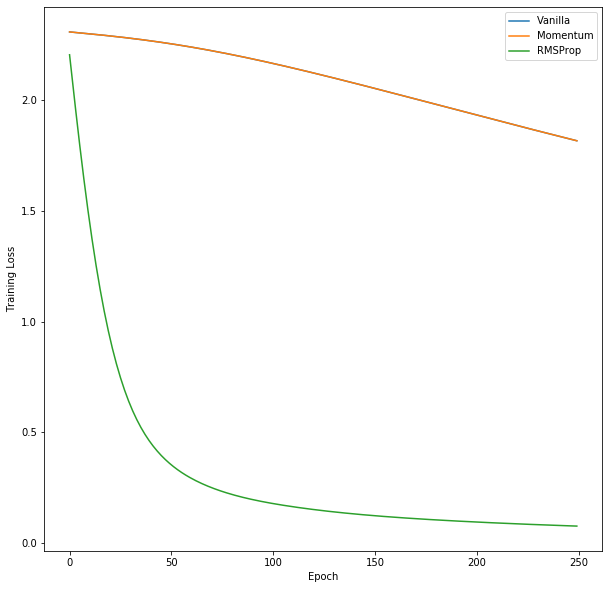

In [15]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Adam Gradient Descent 

Now we put them both together and we get Adam!

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$\hat m_{t} = \frac {m_{t}}{1 - \beta_1^{t}}$$
---

$$\hat v_t = \frac {v_{t}}{1 - \beta_2^{t}}$$
---

$$\theta_t = \theta_{t-1} - \alpha \frac {\hat m_t}{\sqrt{\hat v_t + \epsilon}} \tag{4}$$
---

Play around with the hyperparameters to see if you can get distinctly different behavior from the optimization.

In [18]:
"""
Adam Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add 3 hyper parameters here. Hint! look at the equation above
"""
beta = .6
epsilon = 1.0e-8
beta2 = .6
t = 1

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
Adam_loss = []

"""
You probably need to initialize your variance and momentum here...
"""
mom_W1 = 0
mom_W2 = 0
mom_b1 = 0
mom_b2 = 0

var_W1 = 0
var_W2 = 0
var_b1 = 0
var_b2 = 0

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        mom_W1 = beta*mom_W1 + (1-beta)*grad_W1
        mom_W2 = beta*mom_W2 + (1-beta)*grad_W2
        mom_b1 = beta*mom_b1 + (1-beta)*grad_b1
        mom_b2 = beta*mom_b2 + (1-beta)*grad_b2
        
        mom_W1 = (mom_W1)/(1-beta**t)
        mom_W2 = (mom_W2)/(1-beta**t)
        mom_b1 = (mom_b1)/(1-beta**t)
        mom_b2 = (mom_b2)/(1-beta**t)
        
        var_W1 = beta2*var_W1 + (1-beta2)*grad_W1**2
        var_W2 = beta2*var_W2 + (1-beta2)*grad_W2**2
        var_b1 = beta2*var_b1 + (1-beta2)*grad_b1**2
        var_b2 = beta2*var_b2 + (1-beta2)*grad_b2**2
        
        var_W1 = (var_W1)/(1-beta2**t)
        var_W2 = (var_W2)/(1-beta2**t)
        var_b1 = (var_b1)/(1-beta2**t)
        var_b2 = (var_b2)/(1-beta2**t)
        
        W1 -= mom_W1/np.sqrt(var_W1+epsilon)*eta
        W2 -= mom_W2/np.sqrt(var_W2+epsilon)*eta
        b1 -= mom_b1/np.sqrt(var_b1+epsilon)*eta
        b2 -= mom_b2/np.sqrt(var_b2+epsilon)*eta
        
        t+=1
        
    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    Adam_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.199197 Accuracy 0.491429
Epoch 10 Loss 1.412132 Accuracy 0.868000
Epoch 20 Loss 0.887571 Accuracy 0.888571
Epoch 30 Loss 0.589255 Accuracy 0.899429
Epoch 40 Loss 0.424675 Accuracy 0.903143
Epoch 50 Loss 0.329703 Accuracy 0.906286
Epoch 60 Loss 0.270392 Accuracy 0.910571
Epoch 70 Loss 0.230179 Accuracy 0.914286
Epoch 80 Loss 0.200903 Accuracy 0.916571
Epoch 90 Loss 0.178603 Accuracy 0.917143
Epoch 100 Loss 0.160847 Accuracy 0.918857
Epoch 110 Loss 0.146121 Accuracy 0.920286
Epoch 120 Loss 0.133863 Accuracy 0.920286
Epoch 130 Loss 0.123348 Accuracy 0.922286
Epoch 140 Loss 0.114215 Accuracy 0.923143
Epoch 150 Loss 0.106379 Accuracy 0.923143
Epoch 160 Loss 0.099480 Accuracy 0.923143
Epoch 170 Loss 0.093313 Accuracy 0.922571
Epoch 180 Loss 0.087660 Accuracy 0.924571
Epoch 190 Loss 0.082513 Accuracy 0.925429
Epoch 200 Loss 0.077858 Accuracy 0.925714
Epoch 210 Loss 0.073631 Accuracy 0.926571
Epoch 220 Loss 0.069813 Accuracy 0.926857
Epoch 230 Loss 0.066313 Accuracy 0.928000
Epo

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.plot(Adam_loss, label='Adam')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

In [20]:
"""
Adam Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add 3 hyper parameters here. Hint! look at the equation above
"""
beta = .6
epsilon = 1.0e-8
beta2 = .6
t = 1

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
max_loss = []

"""
You probably need to initialize your variance and momentum here...
"""
mom_W1 = 0
mom_W2 = 0
mom_b1 = 0
mom_b2 = 0

var_W1 = 0
var_W2 = 0
var_b1 = 0
var_b2 = 0

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        mom_W1 = beta*mom_W1 + (1-beta)*grad_W1
        mom_W2 = beta*mom_W2 + (1-beta)*grad_W2
        mom_b1 = beta*mom_b1 + (1-beta)*grad_b1
        mom_b2 = beta*mom_b2 + (1-beta)*grad_b2
        
        mom_W1 = (mom_W1)/(1-beta**t)
        mom_W2 = (mom_W2)/(1-beta**t)
        mom_b1 = (mom_b1)/(1-beta**t)
        mom_b2 = (mom_b2)/(1-beta**t)
        
        var_W1 = np.maximum(beta*var_W1,abs(grad_W1))
        var_W2 = np.maximum(beta*var_W2,abs(grad_W2))
        var_b1 = np.maximum(beta*var_b1,abs(grad_b1))
        var_b2 = np.maximum(beta*var_b2,abs(grad_b2))
        
        W1 -= mom_W1/var_W1*eta
        W2 -= mom_W2/var_W2*eta
        b1 -= mom_b1/var_b1*eta
        b2 -= mom_b2/var_b2*eta
        
        t+=1
        
    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    max_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.191533 Accuracy 0.577714
Epoch 10 Loss 1.369682 Accuracy 0.871429
Epoch 20 Loss 0.841218 Accuracy 0.890571
Epoch 30 Loss 0.552602 Accuracy 0.899143
Epoch 40 Loss 0.398553 Accuracy 0.902571
Epoch 50 Loss 0.311156 Accuracy 0.907429
Epoch 60 Loss 0.256806 Accuracy 0.911143
Epoch 70 Loss 0.219852 Accuracy 0.914000
Epoch 80 Loss 0.192987 Accuracy 0.915714
Epoch 90 Loss 0.172331 Accuracy 0.917143
Epoch 100 Loss 0.155763 Accuracy 0.916286
Epoch 110 Loss 0.141966 Accuracy 0.917143
Epoch 120 Loss 0.130322 Accuracy 0.918571
Epoch 130 Loss 0.120375 Accuracy 0.920286
Epoch 140 Loss 0.111689 Accuracy 0.921429
Epoch 150 Loss 0.103988 Accuracy 0.922000
Epoch 160 Loss 0.097065 Accuracy 0.922857
Epoch 170 Loss 0.090816 Accuracy 0.924857
Epoch 180 Loss 0.085252 Accuracy 0.924000
Epoch 190 Loss 0.080115 Accuracy 0.924571
Epoch 200 Loss 0.075413 Accuracy 0.926000
Epoch 210 Loss 0.071164 Accuracy 0.926000
Epoch 220 Loss 0.067287 Accuracy 0.926000
Epoch 230 Loss 0.063721 Accuracy 0.926286
Epo

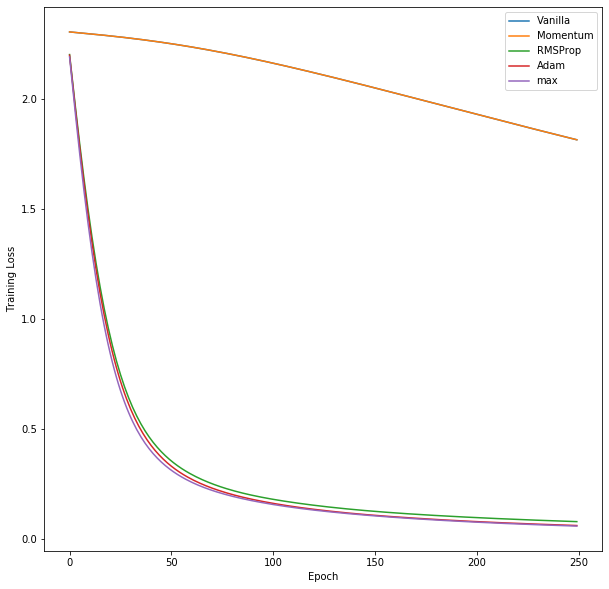

In [25]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.plot(Adam_loss[0:250], label='Adam')
plt.plot(Adam_loss[250:], label='max')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()